<img src='./img/joint_school_banner_2.png' alt='Joint training school - atmosphere' align='center' width='100%'></img>

<br>

# Fire monitoring with satellite data - Siberian wildfires 2021

### About

Smoke from wildfires in parts of Siberia have set undesirable new records, with experts recording plumes reaching the geographic North Pole for the first time in recorded history. 

The forest fires, which occurred in the Siberian regions Sakha, Dzhigda and Okhotsk, have set new records betweeen June and August 2021. By mid-August, fires have burned more than 150,000 square kilometres of forest and tundra in Siberia - an area larger than the Netherlands, Belgium, and Denmark combined.

The long-term data are showing worrying trends, with average fire seasons in Siberia and many other parts of the world increasing in intensity and duration. With an increase of the average annual temperature in Siberia, fires in the region starting, on average, earlier and further north than they used to. Wirlfires in the Artic are a new environmental threat. 

<br>

<img src='./img/wildfires.jpg' alt='wildfires' align='center' width='60%'></img>

<i>Sentinel-3 OLCI True Color RGB over Siberia in 2021</i>

<br>

Satellites are crucial to monitor wildfires and their impact in the atmosphere and on land. This is even more important in regions where control and monitoring from ground is particularly difficult.<br>

The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the fires on 12 August 2021 with the following data products:
<a id="top"></a>
- [Copernicus Sentinel-3 OLCI - Level 1B - False-color RGB composite](#fire_s3)
- [Metop-A/B/C GOME-2 - Level 3 - Absorbing Aerosol Index (AAI)](#fire_aai)
- [Copernicus Sentinel-5P TROPOMI - Level 2 - Carbon Monoxide](#fire_s5p)


More information in the EUMESAT Science Blog from 17 August 2021: 
> [Smoke from wildfires in parts of Siberia have set undesirable new records](https://www.eumetsat.int/science-blog/siberian-smoke-plume-reaches-north-pole-fires-set-other-unwanted-records)

### How to access the data

#### Copernicus Sentinel-3 OLCI Level 1B data

Sentinel-3 OLCI Level 1B data are available via the [Copernicus Online Data Access (CODA) service](https://coda.eumetsat.int/#/home). You have to have an account for the [EUMETSAT Earth Observation Portal](https://eoportal.eumetsat.int/) in order to be able to access data on CODA.

#### Metop-A/B/C GOME-2 Level 3 AAI data

AAI Level 3 data are available for download via [TEMIS](http://www.temis.nl/airpollution/absaai/), a web-based service for atmospheric satellite data products maintained by KNMI. TEMIS provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C. Go to the [download page](https://www.temis.nl/airpollution/absaai/#GOME2_AAI).

#### Copernicus Sentinel-5P TROPOMI Level 2 UV AI data

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home). You can login with the following credentials:
* **Username**: `s5pguest`
* **Password**: `s5pguest`

### Module outline
* [1 - Copernicus Sentinel-3 OLCI Level 1B RGB composite](#fire_s3)
  * [1.1 - Unzip and inspect Sentinel-3 data structure](#fire_load_s3)
  * [1.2 - Load OLCI channel information as a xarray.DataArray](#channel_info_s3)
  * [1.3 - Load OLCI geographic coordinates as xarray.DataArray](#load_geocoord_s3)
  * [1.4 - Select OLCI channels for a false-color RGB image](#channel_select_s3)
  * [1.5 - Advanced image processing - Normalization and histogram equalization](#image_processing_s3)
  * [1.6 - Visualize a georeferenced Sentinel-3 Level 1 RGB False Color composite over Siberia on 12 August 2021](#visualize_s3)
* [2 - Metop-A/B/C GOME-2 Level 3 AAI data](#fire_aai)
  * [2.1 - Load the gridded AAI data from the three satellites Metop-A, -B and -C](#fire_load_aai)
  * [2.2 - Concatenate the data from the three satellites Metop-A, -B and -C](#fire_concat_aai)
  * [2.3 - Combine AAI data from the three satellites Metop-A, -B and -C onto one single grid](#fire_combine_aai)
  * [2.4 - Visualize global Absorbing Aerosol Index data for 12 August 2021](#fire_visualize_aai)
* [3 - Copernicus Sentinel-5P TROPOMI Level 2 Carbon Monoxide data](#fire_s5p)
  * [3.1 - Load one Sentinel-5P Level 2 CO file with xarray](#fire_load_s5p)
  * [3.2 - Create a geographical subset over Siberia](#s5p_geographical_subset)
  * [3.3 - Visualize Sentinel-5P TROPOMI Carbon Monoxide Level 2 data over Siberia on 12 August 2021](#fire_visualize_s5p)

<hr>

#### Load required libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ./functions.ipynb

<hr>

## <a id='fire_s3'></a>1. Sentinel-3 OLCI Level 1B data

Images taken by the EUMETSAT-operated Copernicus Sentinel-3 satellite mission show brown-coloured smoke from the fires sprawling across Siberia and up towards the North Pole, where researchers have confirmed that the smoke plume from the fires reached the geographic North Pole. In 2021, this was the first time this has been recorded since comprehensive records began in 2003.

<img src='../img/20210812_s3_olci.png' alt='False-Color composite of Sentinel-3 OLCI Level-1B - 12 August 2021' align='centre' width='50%'></img>

<br>

### <a id='fire_load_s3'></a> 1.1 Unzip and inspect Sentinel-3 data structure

Sentinel-3 data are dissimenated as zip archives. For this reason, the first step is to extact the data files from the zip archive. You can use the function `extractall()` from the Python library `zipfile` to extract the content of a zipped folder.

In [3]:
import zipfile
with zipfile.ZipFile('./data/fire/s3/S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T073843_0179_055_346_1980_LN1_O_NT_002.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/fire/s3/')

The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory `./data/fire/s3/S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T073843_0179_055_346_1980_LN1_O_NT_002.SEN3/`. You see that the files with the channel information follow the same naming and end with `_radiance.nc`.

In [4]:
olci_dir = './data/fire/s3/S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T073843_0179_055_346_1980_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[5])

time_coordinates.nc
Oa01_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa04_radiance.nc
Oa05_radiance.nc
Oa06_radiance.nc
Oa07_radiance.nc
Oa08_radiance.nc
Oa09_radiance.nc
Oa10_radiance.nc
Oa11_radiance.nc
Oa12_radiance.nc
Oa13_radiance.nc
Oa14_radiance.nc
Oa15_radiance.nc
Oa16_radiance.nc
Oa17_radiance.nc
Oa18_radiance.nc
Oa19_radiance.nc
Oa20_radiance.nc
Oa21_radiance.nc
qualityFlags.nc
instrument_data.nc
removed_pixels.nc
geo_coordinates.nc
tie_geo_coordinates.nc
tie_meteo.nc
tie_geometries.nc


<br>

### <a id='channel_info_s3'></a>1.2 Load OLCI channel information as a xarray.DataArray

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset()`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `combine=by_coords`. The result is a `xarray` object with 21 data variables. Each channel is represented as a data variable.

In [5]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes: (12/16)
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-13T07:38:43Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

### <a id='load_geocoord_s3'></a>1.3 Load OLCI geographic coordinates as xarray.DataArray

If you want to georeference your image, you have to load the geographic coordinates file. You can load it with the xarray function `open_dataset()`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let us store the latitude and longitude data as `lat` and `lon` variables respectively.

In [6]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/16)
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-13T07:38:43Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

In [7]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<br>

### <a id='channel_select_s3'></a>1.4 Select OLCI channels for a false-color RGB image

Depending on the combination of different OLCI channels, your RGB image might highlight specific phenomena. The channel combination for a False Color RGB image which highlights vegetation as red and smoke browninsh is as follows:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

You can use the function [select_channels_for_rgb](./functions.ipynb#rgb_channels), which allows you to select three channels individually.

In [8]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 
                                                    'Oa17_radiance', 
                                                    'Oa05_radiance', 
                                                    'Oa02_radiance')
red_fc

<xarray.DataArray 'Oa17_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-b600edbf0b547eb2278bf2a0bd5dbbe5Oa17_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa17_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa17
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

<br>

### <a id='image_processing_s3'></a>1.5 Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intensity and can improve the constrast. You can use the function [normalize](./functions.ipynb#normalize) to normalize each RGB channel. At the end, you can bring the three channels together into one `rgb` array with the function `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [9]:
redn = normalize(red_fc)
greenn = normalize(green_fc)
bluen = normalize(blue_fc)

In [10]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

<br>

You can now plot the rgb image to see if further image processing methods might need to be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

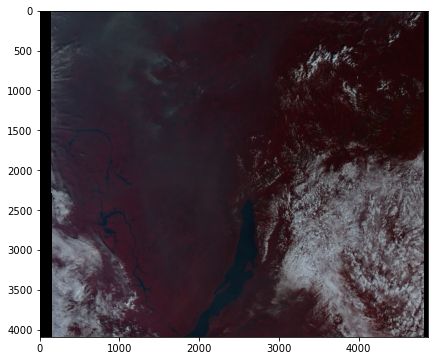

In [11]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<br>

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization easy. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the `rgb` data array.

In [12]:
rgb = exposure.equalize_adapthist(rgb)

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

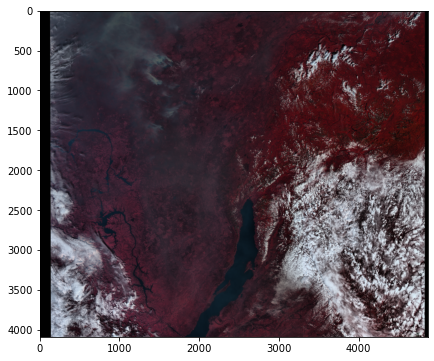

In [13]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<br>

### <a id='visualize_s3'></a>1.6 Visualize a georeferenced Sentinel-3 Level 1 RGB False Color composite over Siberia on 12 August 2021

The final step is to georeference the `RGB` image. Therefore, you need the `lat` and `lon` information extracted above.

Let us plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB, you have to map first the rgb array to a colour array.

In [14]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

<br>

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines. You can use the function [visualize_s3_pcolormesh()](./functions.ipynb#visualize_s3_pcolormesh) to do so.

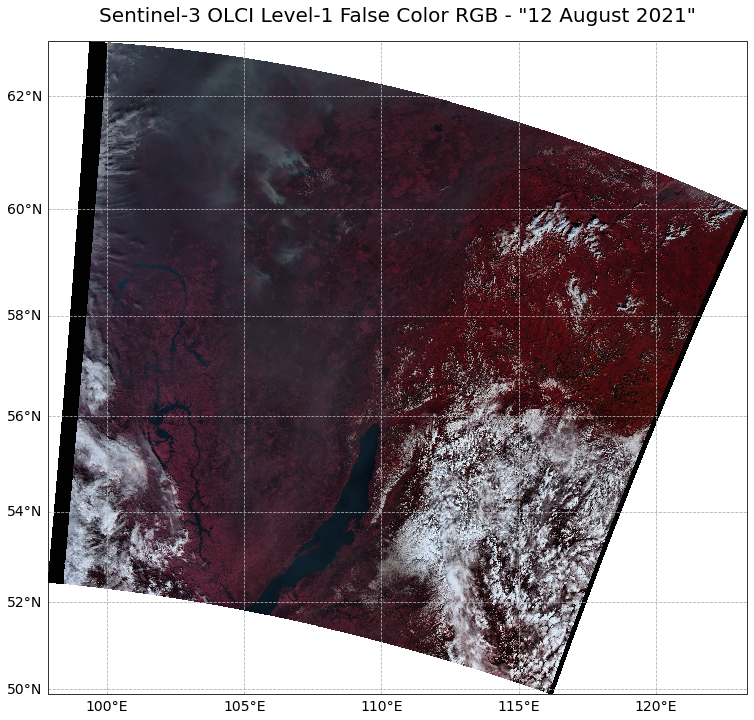

In [15]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red_fc, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 False Color RGB - "12 August 2021"')

<br>

## <a id="fire_aai"></a>2. Metop-A/B/C GOME-2 Level 3 Absorbing Aerosol Index

The Absorbing Aerosol Index (AAI) is an indicator of the presence of elevated absorbing aerosols in the Earth's atmosphere - such as soot particles in fire smoke which absorb and scatter incoming sunlight. The AAI data from 12 August 2021 show clearly the scale and extent of fires across Siberia.

<img src='./img/20210812_aai.png' alt='Absorbing Aerosol Index' align='centre' width='70%'></img>

### <a id='fire_load_aai'></a>2.1 Load the gridded AAI data from the three satellites Metop-A, -B and -C

The data is in the folder `/data/fire/gome2/`. Since the data is distributed in the `NetCDF` format, you can use the xarray function `open_dataset()` to load one single file to better understand the data structure.

In [16]:
file = './data/fire/gome2/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20210812-fv1.8.nc'
aai_gome2a = xr.open_dataset(file)
aai_gome2a

<xarray.Dataset>
Dimensions:                  (longitude: 360, latitude: 180)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes: (12/32)
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 12-08-2021
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

The output of the xarray `Dataset` above shows that one file contains the data of three variables: <br>
* `absorbing_aerosol_index`,
* `number_of_observations`, and
* `solar_zenith_angle`. 

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the variable's `DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [17]:
aai_a = aai_gome2a['absorbing_aerosol_index']
aai_a


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

Let us repeat the above steps for the AAI data from Metop-B satellite.

In [18]:
file = './data/fire/gome2/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20210812-fv1.8.nc'
aai_gome2b = xr.open_dataset(file)

aai_b = aai_gome2b['absorbing_aerosol_index']
aai_b


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.370541, -0.371094, -0.379229, ..., -0.388021, -0.388342, -0.381227],
       [-0.415066, -0.430058, -0.405528, ..., -0.43855 , -0.440324, -0.43429 ],
       [-0.418262, -0.385545, -0.410825, ..., -0.379155, -0.392646, -0.389337]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

Let's repeat the above steps for the AAI data from Metop-C.

In [19]:
file = './data/fire/gome2/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20210812-fv1.8.nc'
aai_gome2c = xr.open_dataset(file)

aai_c = aai_gome2c['absorbing_aerosol_index']
aai_c


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.127714, -0.141083, -0.148726, ..., -0.169669, -0.153791, -0.128036],
       [-0.242663, -0.241277, -0.208425, ..., -0.242437, -0.248455, -0.241949],
       [-0.186109, -0.154851, -0.212029, ..., -0.196792, -0.194117, -0.160715]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

### <a id='fire_concat_aai'></a>2.2 Concatenate the data from the three satellites Metop-A, -B and -C

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A, -B and -C. Let us call the new dimension `satellite`. 
You can use the `concat()` function from the xarray library.

The result is a three-dimensional `DataArray`, with the dimensions `satellite`, `latitude` and `longitude`. You can see that the resulting `DataArray` holds coordinate information for the two spatial dimensions `longitude` and `latitude`, but not for `satellite`.

In [20]:
aai_concat = xr.concat([aai_a,aai_b, aai_c], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, latitude: 180, longitude: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.37054113, -0.37109375, -0.3792295 , ..., -0.38802078,
         -0.3883424 , -0.38122678],
        [-0.41506633, -0.43005776, -0.4055277 , ..., -0.43855026,
         -0.44032437, -0.43428954],
        [-0.41826242, -0.3855448 , -0.4108255 , ..., -0.37915498,
         -0.39264563, -0.38933685]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.12771402, -0.14108314, -0.14872631, ..., -0.16966872,
         -0.1537914 , -0.1280362 ],
        [-0.24266298, -0.241277  , -0.20842499, ..., -0.24243732,
         -0.24845518, -0.24194944],
        [-0.1861089 , -0.15485092, -0.2120285 , ..., -0.19679175,
         -0.19411677, -0.16071533]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

### <a id='fire_combine_aai'></a>2.3 Combine AAI data from the three satellites Metop-A, -B and -C onto one single grid

Since the final aim is to combine the data from the three satellites Metop-A, -B and -C onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reducer function `mean()` to the `aai_concat` data array. The dimension (`dim`) to be reduced shall be the `satellite` dimension.

This function builds the average of all data points within a grid cell. The resulting data array has two dimensions: `latitude` and `longitude`.

In [21]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.24912757, -0.25608844, -0.2639779 , ..., -0.27884474,
        -0.2710669 , -0.2546315 ],
       [-0.32886466, -0.33566737, -0.30697635, ..., -0.3404938 ,
        -0.34438977, -0.3381195 ],
       [-0.30218565, -0.27019787, -0.311427  , ..., -0.28797337,
        -0.2933812 , -0.27502608]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

### <a id='fire_visualize_aai'></a>2.4 Visualize global Absorbing Aerosol Index data for 12 August 2021

The final step is to visualize the Absorbing Aerosol Index data. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh) to do so.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by using `str(aai_gome2a.description.split()[4])`, you can add the valid time step extracted from the file name of `aai_gome2a` to the title of the plot.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Absorbing aerosol index averaged for each grid cell 12-08-2021'}>)

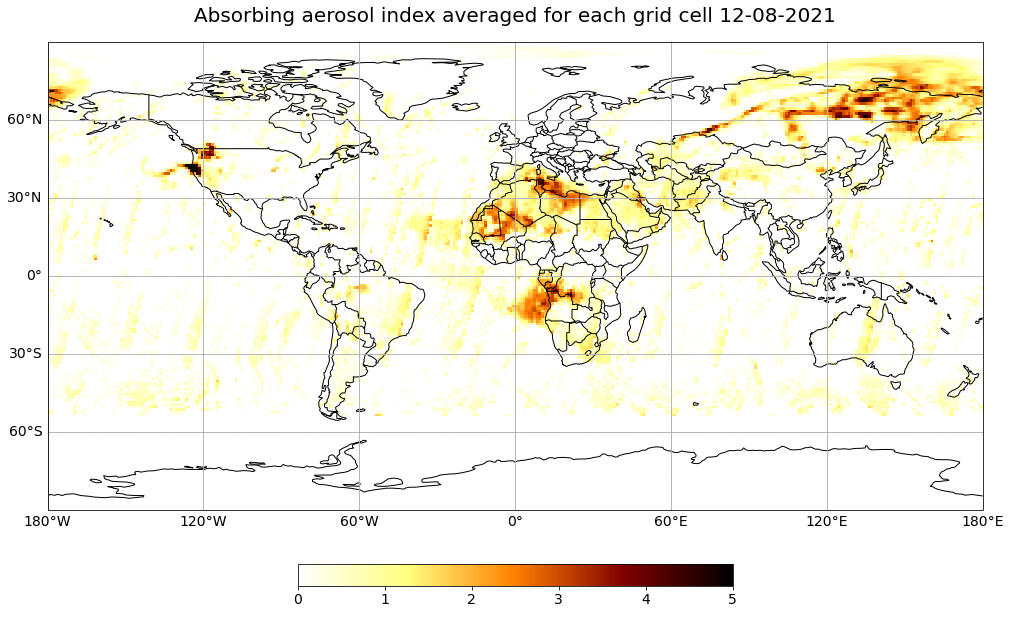

In [22]:
visualize_pcolormesh(data_array = aai_combined[:,:],
                     longitude = aai_combined.longitude, 
                     latitude = aai_combined.latitude,
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'afmhot_r', 
                     unit = ' ',
                     long_name = aai_a.long_name + ' ' + str(aai_gome2a.description.split()[4]), 
                     vmin = 0, 
                     vmax = 5)


## <a id='fire_s5p'></a> 3. Sentinel-5P Level 2 Carbon Monoxide

The subsequent example introduces the Sentinel-5P TROPOMI total column of carbon monoxide product. Carbon Monoxide is a good trace gas in order to monitor and track fire occurences.

<img src='./img/s5p_fire_siberia.png' alt='S5P CO' align='centre' width='50%'></img>

<br>

### <a id='fire_load_s5p'></a> 3.1 Load one Sentinel-5P Level 2 CO file with xarray

A Sentinel-5P TROPOMI Carbon Monoxide Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load multiple `netCDF` files at once with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 12 August 2021 and inspect the data structure:

In [24]:
s5p = xr.open_dataset('./data/fire/s5p/S5P_OFFL_L2__CO_____20210812T034159_20210812T052329_19845_02_020200_20210813T173323.nc', group='PRODUCT')
s5p

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 215, time: 1, corner: 4, layer: 50)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2021-08-12
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 4.95e+04 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 ...

You see that the loaded data object contains five dimensions and five data variables:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `layer`


* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `ga_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `carbonmonoxide_total_column`: Vertically integrated CO column density
  * `carbonmonoxide_total_column_precision`: Standard error of the vertically integrate CO column

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the atmosphere mole content of carbon monoxide, has the unit `mol per m-2`, and has three dimensions, `time`, `scanline` and `groundpixel` respectively.

In [25]:
s5p_co = s5p['carbonmonoxide_total_column']
s5p_co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2021-08-12
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

You can retrieve the array values of the variable with squared brackets: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [26]:
s5p_co_1208 = s5p_co[0,:,:]
s5p_co_1208

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

The attributes of the `xarray.DataArray` hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from `mol per m`<sup>`2`</sup> to `molecules per cm`<sup>`2`</sup>.


In [27]:
conversion_factor = s5p_co_1208.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

Additionally, you can save the attribute `longname`, which you can make use of when visualizing the data.

In [28]:
longname = s5p_co.long_name
longname

'Vertically integrated CO column'

### <a id='s5p_geographical_subset'></a>3.2 Create a geographical subset over Siberia

You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to north-eastern Siberia with the following bounding box information:

In [29]:
lonmin=95.
lonmax=150.
latmin=40.
latmax=75.

You can use the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset) to subset an `xarray.DataArray` based on a given bounding box.

In [30]:
s5p_co_subset = generate_geographical_subset(xarray=s5p_co_1208, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
s5p_co_subset

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 767, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.506e+03 2.507e+03 ... 3.271e+03 3.272e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 33.98 34.16 ... 76.51 76.4
    longitude     (scanline, ground_pixel) float32 111.9 112.3 ... 143.5 144.8
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

### <a id="fire_visualize_s5p"></a>3.3 Visualize Sentinel-5P TROPOMI Carbon Monoxide Level 2 data over Siberia on 12 August 2021

You can plot data arrays of type `numpy` with matplotlib's `pcolormesh` function. In combination with the library [cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

In order to make it easier to visualize the Carbon Monoxide values, we apply the conversion factor to the `xarray.DataArray`. This converts the Carbon Monoxide values from *mol per m<sup>2</sup>* to *molecules per cm<sup>2</sup>*.

In [31]:
s5p_co_converted = s5p_co_subset*conversion_factor
s5p_co_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 767, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.506e+03 2.507e+03 ... 3.271e+03 3.272e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 33.98 34.16 ... 76.51 76.4
    longitude     (scanline, ground_pixel) float32 111.9 112.3 ... 143.5 144.8

For visualization, you can use the function [visualize_pcolormesh()](./functions.ipynb#visualize_pcolormesh) to visualize the data. The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

Note: Multiplying the DataArray values with 1e<sup>-18</sup> improves the readibility of the map legend.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column - 2021-08-12'}>)

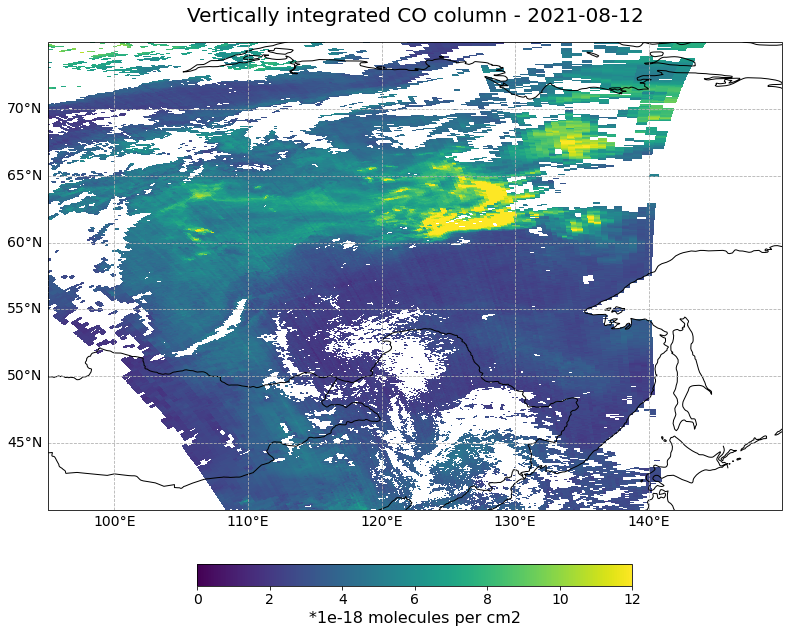

In [32]:
visualize_pcolormesh(data_array=s5p_co_converted*1e-18, 
                     longitude=s5p_co_converted.longitude, 
                     latitude=s5p_co_converted.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='*1e-18 molecules per cm2', 
                     long_name=longname + ' - ' + str(s5p_co_converted.time.dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=12, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


<br>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.